### Load libraries

In [1]:
import contextlib
import dataclasses
import pathlib
import sys
import warnings

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10, cifar100, imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip
from src.pretrain.probes import knn_probe, linear_probe

2023-03-09 20:02:23.904568: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Load datasets

In [21]:
def get_ds(model_id: str):
    # dataset_cfg = cifar10.CIFAR10()
    dataset_cfg = cifar100.CIFAR100()
    embedder_cfg = openai_clip.OpenaiClipConfig(id=model_id)

    embedding_cfg = gen_embeddings.Config(
        dataset_cfg=dataset_cfg,
        embedder_cfg=embedder_cfg,
        save_dir="/projects/scaling/embeddings",
    )

    return EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
        np.float32
    )

In [3]:
MODEL_IDS = [
    "openai/ViT-B/32",
    "openai/ViT-B/16",
    "openai/ViT-L/14",
    "openai/ViT-L/14@336px",
]

DSS = {model_id: get_ds(model_id) for model_id in MODEL_IDS}

### Dataset info

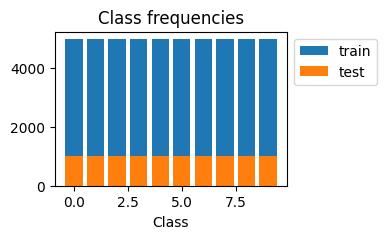

In [4]:
fig = probe_embeddings.plot_class_frequencies(DSS[MODEL_IDS[0]])
fig.set_size_inches((3, 2))

### Calculate PCA

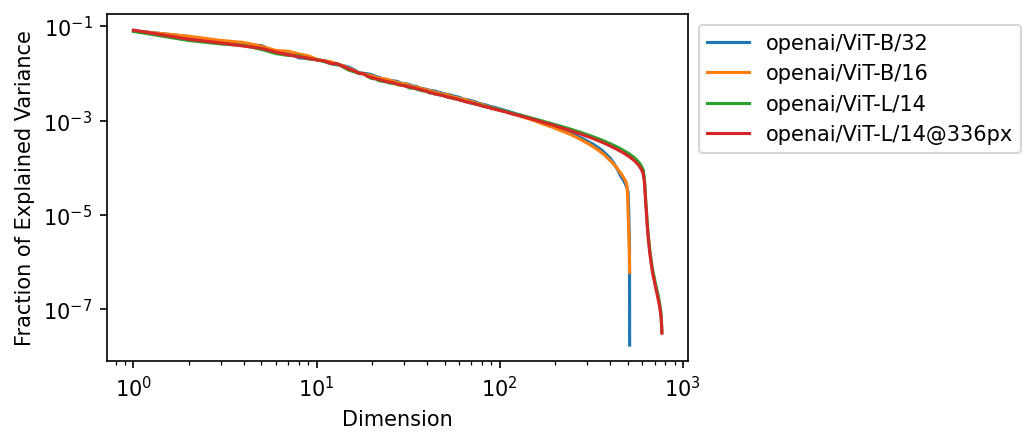

In [5]:
def center_and_scale(xs: np.ndarray):
    return (xs - xs.mean(axis=0)) / xs.std(axis=0)

plt.figure(dpi=150, figsize=(5, 3))
for model_id in MODEL_IDS:
    xs = center_and_scale(DSS[model_id].xs_train)

    pca = PCA(n_components=xs.shape[1])
    pca.fit(xs)
    variance_ratios = pca.explained_variance_ratio_

    plt.plot(
        np.arange(len(variance_ratios)) + 1,
        variance_ratios,
        label=model_id,
    )
    plt.yscale("log")
    plt.xscale("log")

# Legend on outside top right
plt.xlabel("Dimension")
plt.ylabel("Fraction of Explained Variance")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Scaling as a function of reduced dimension

In [12]:
class FilteredWriter:
    """
    Filters out an annoying messages.
    From https://github.com/AlignmentResearch/KataGoVisualizer/blob/main/notebooks/notebooks/paper/estimate-flops-katago.ipynb.
    """

    def write(self, message):
        if message.strip() == "":
            return

        if "L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)" in message:
            return

        if "L-BFGS line search failed" in message:
            return

        warnings.warn(message)

results = []
for model_id in MODEL_IDS:
    ds = DSS[model_id]

    pca = PCA(n_components=ds.xs_train.shape[1])
    pca.fit(center_and_scale(ds.xs_train))
    xs_train_pca = pca.transform(center_and_scale(ds.xs_train))
    xs_test_pca = pca.transform(center_and_scale(ds.xs_test))

    for i in tqdm(range(1, 100)):
        sub_ds = dataclasses.replace(
            ds,
            xs_train=xs_train_pca[:, :i],
            xs_test=xs_test_pca[:, :i],
        )

        with contextlib.redirect_stdout(FilteredWriter()):  # type: ignore
            with warnings.catch_warnings():
                # Filter out "RuntimeWarning: divide by zero encountered in log"
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                results.append(
                    linear_probe.run_experiment(
                        ds=sub_ds,
                        c=100,
                        use_gpu=True,
                        report_per_class_results=False,
                    )
                    | dict(dims=i, model_id=model_id)
                )

df = pd.DataFrame(results)
df["err"] = 1 - df.acc

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

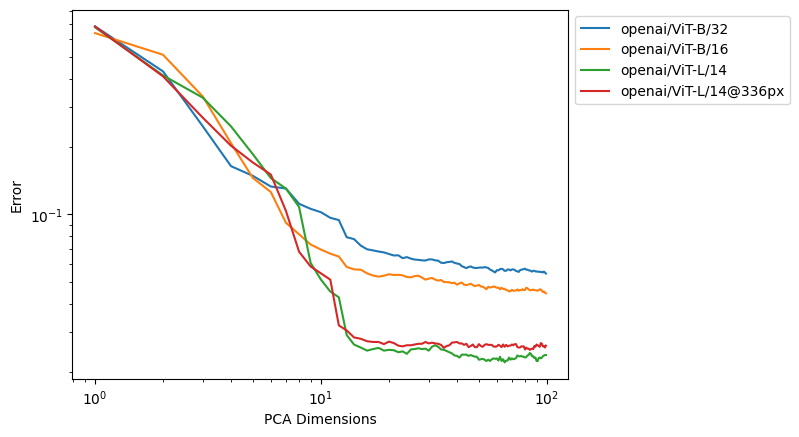

In [16]:
for model_id in MODEL_IDS:
    cdf = df.query(f"model_id == @model_id")
    plt.plot(cdf.dims, cdf.err, label=model_id)

plt.xlabel("PCA Dimensions")
plt.ylabel("Error")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Intrinsic dimension (2-NN method)
See https://www.nature.com/articles/s41598-017-11873-y#Sec2 for details.

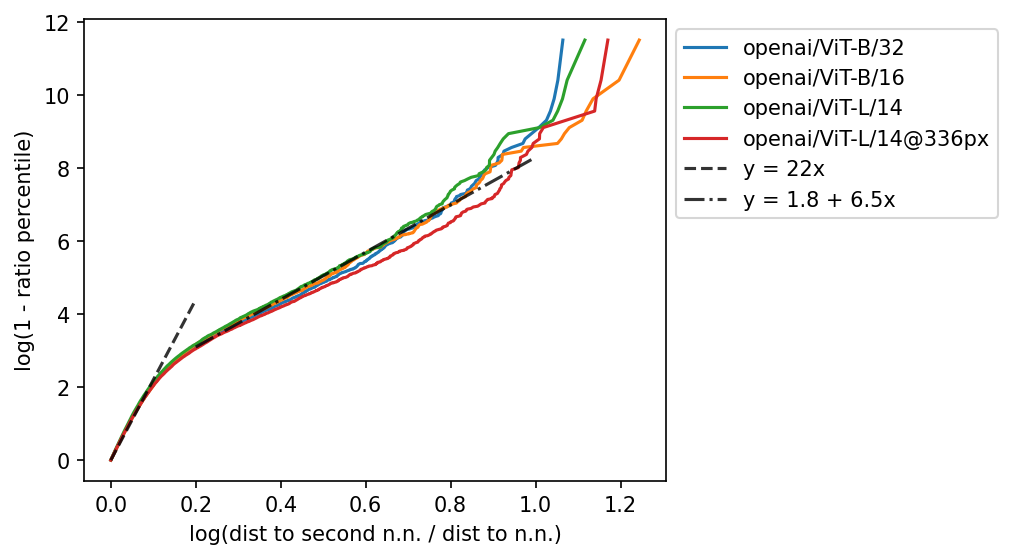

In [35]:
plt.figure(dpi=150, figsize=(5, 4))
for model_id in MODEL_IDS:
    ds = DSS[model_id]

    # For each points in train set, find distance to nearest neighbor in train set
    nn2 = cuml.neighbors.NearestNeighbors(n_neighbors=3)
    nn2.fit(ds.xs_train)
    distances, _ = nn2.kneighbors(ds.xs_train)

    ratios = np.sort(distances[:, 2] / distances[:, 1])
    fracs = (0.5 + np.arange(len(ratios))) / len(ratios)

    plt.plot(np.log(ratios), -np.log(1 - fracs), label=model_id)

# Legend on outside top right

slope1 = 22
plt.plot(
    np.linspace(0, 0.2, 100),
    slope1 * np.linspace(0, 0.2, 100),
    label=f"y = {slope1}x",
    linestyle="--",
    color="black",
    alpha=0.8
)
slope2 = 6.5
plt.plot(
    np.linspace(0.2, 1.0, 100),
    3.1 - slope2 * 0.2 + slope2 * np.linspace(0.2, 1.0, 100),
    label=f"y = {3.1 - slope2 * 0.2} + {slope2}x",
    linestyle="-.",
    color="black",
    alpha=0.8
)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("log(dist to second n.n. / dist to n.n.)")
plt.ylabel("log(1 - ratio percentile)")
plt.show()

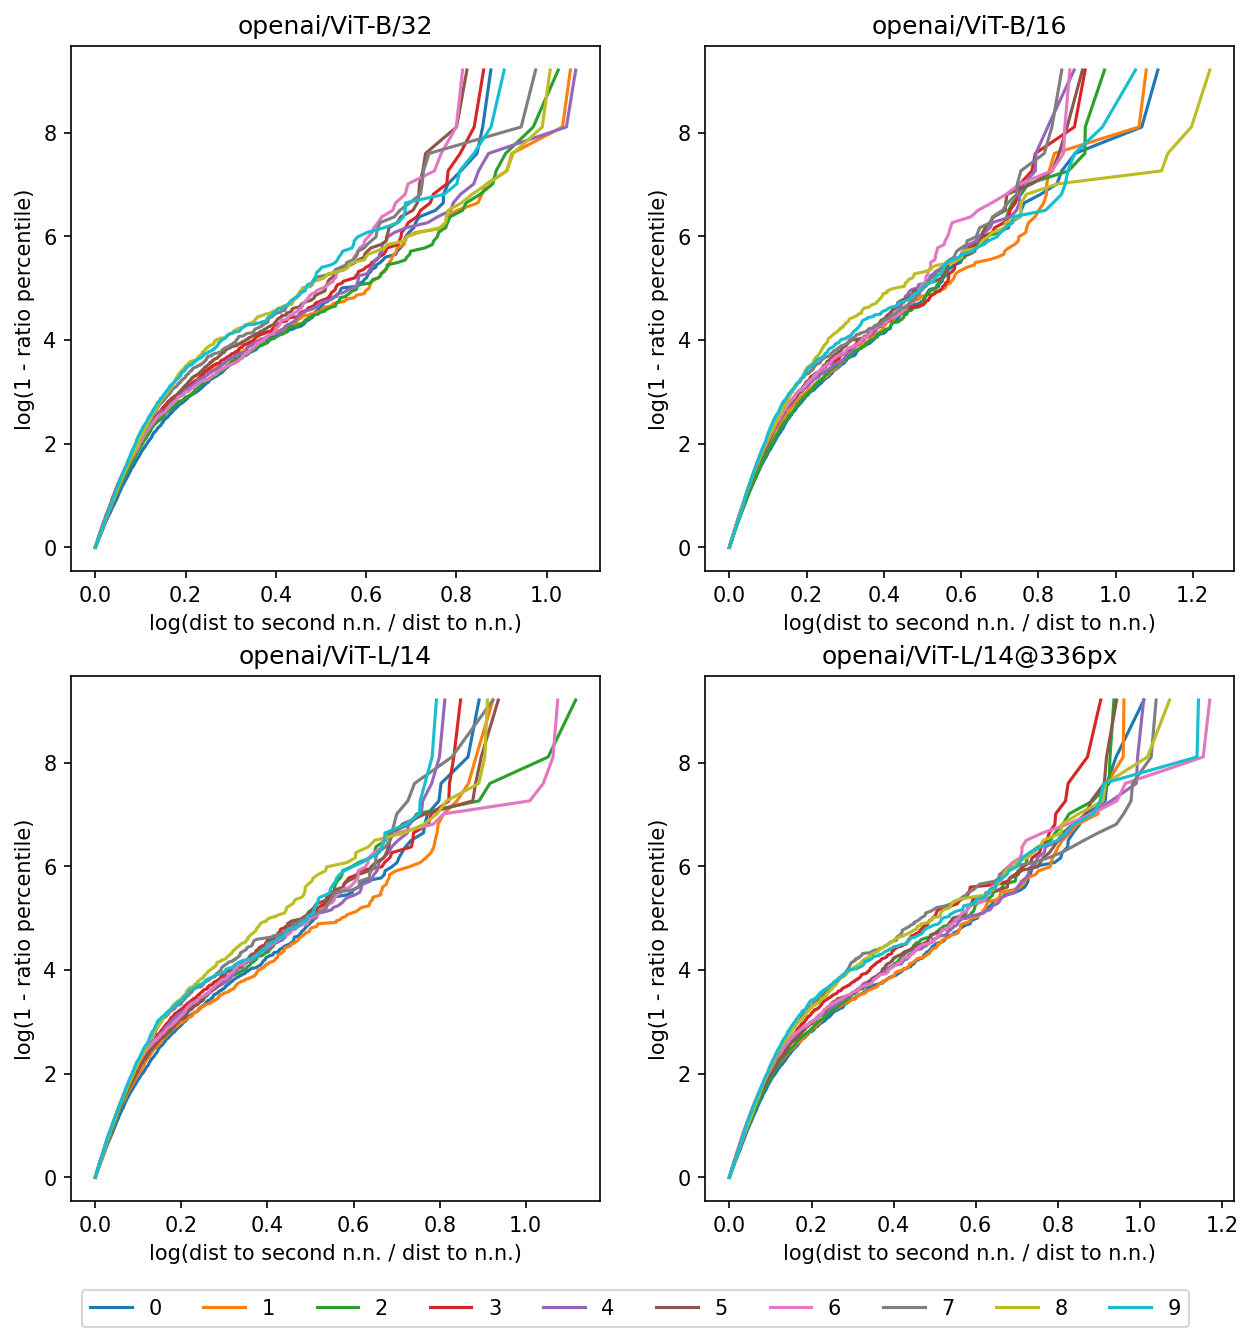

In [46]:
plt.figure(dpi=150, figsize=(10, 10))
for i, model_id in enumerate(MODEL_IDS):
    plt.subplot(2, 2, i + 1)
    for cls_idx in range(10):
        ds = DSS[model_id]
        xs = ds.xs_train[ds.ys_train == cls_idx]

        # For each points in train set, find distance to nearest neighbor in train set
        nn2 = cuml.neighbors.NearestNeighbors(n_neighbors=3)
        nn2.fit(xs)
        distances, _ = nn2.kneighbors(xs)

        ratios = np.sort(distances[:, 2] / distances[:, 1])
        fracs = (0.5 + np.arange(len(ratios))) / len(ratios)

        plt.plot(np.log(ratios), -np.log(1 - fracs), label=cls_idx)
        if i == 2:
            plt.legend(loc="upper left", bbox_to_anchor=(0, -0.15), ncol=10)
        plt.xlabel("log(dist to second n.n. / dist to n.n.)")
        plt.ylabel("log(1 - ratio percentile)")
        plt.title(model_id)